In [1]:
%pylab inline
matplotlib.style.use("ggplot")
import pandas


Populating the interactive namespace from numpy and matplotlib


Die Datensätze, die in diesem Notebook verwendet werden, sind im Open-Data-Portal der Deutschen Bahn von der DB Station&Service AG veröffentlicht wurden ([1](http://data.deutschebahn.com/datasets/stationsdaten/), [2](http://data.deutschebahn.com/datasets/bahnsteig/)) und unterliegen der [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)-Lizenz.

In [2]:
data1 = pandas.read_csv("http://data.deutschebahn.com/datasets/bahnsteig/DBSuS-Bahnsteigdaten-Stand2015-10.csv", sep=';')
data2 = pandas.read_csv("http://data.deutschebahn.com/datasets/stationsdaten/DBSuS-Uebersicht_Bahnhoefe-Stand2015-10.csv", sep=';')[["Bf. Nr.", "Station", "Fernverkehr", "Nahverkehr"]]
data = data1.merge(data2, right_on="Bf. Nr.", left_on="bf_nr").drop("Bf. Nr.", 1)
data.columns
data.columns = ["Bahnhofsnummer", "Bahnsteigsnummer", "Bahnsteigskantennummer", "Bezeichnung", "Baulaenge", "Kantenhoehe", "Bahnhofsname", "Fernverkehr", "Nahverkehr"]
data[["Baulaenge"]] = data["Baulaenge"].map(lambda v: v.replace(",", ".")).astype("float")
data[["Fernverkehr"]] = data["Fernverkehr"].map(lambda v: True if v == "ja" else False)
data[["Nahverkehr"]] = data["Nahverkehr"].map(lambda v: True if v == "ja" else False)
data[["Bahnhofsname"]] = data["Bahnhofsname"].map(lambda v: v.decode("iso-8859-1").encode("utf-8"))

In [3]:
def plot_hist(data, xtickstep=1):
    dmax = data.max()
    data.plot(kind='hist', xticks=np.arange(0, dmax, xtickstep), bins=np.arange(0, dmax) + 0.5, logy=True, width=0.8)
    plt.xlim([0, dmax.item()])

# Gleise

In [4]:
d = data[["Bahnhofsnummer", "Bahnhofsname", "Bahnsteigsnummer", "Bezeichnung"]].drop_duplicates().drop(["Bahnsteigsnummer"], 1).groupby(["Bahnhofsnummer", "Bahnhofsname"]).count()
d.columns = ["Anzahl Gleise"]
d.nlargest(10, "Anzahl Gleise")

,,Anzahl Gleise
Bahnhofsnummer,Bahnhofsname,
4234,München Hbf,38
1866,Frankfurt (Main) Hbf,31
3631,Leipzig Hbf,22
4593,Nürnberg Hbf,22
6071,Stuttgart Hbf,18
1289,Dortmund Hbf,16
1401,Düsseldorf Hbf,16
2457,Hagen Hbf,16
3107,Karlsruhe Hbf,16


In [5]:
d.describe()

,Anzahl Gleise
count,5369.000000
mean,2.221829
std,1.637558
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,38.000000


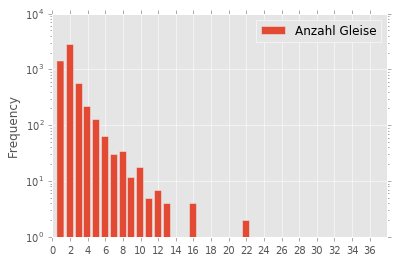

In [6]:
plot_hist(d, xtickstep=2)

# Bahnsteige

In [7]:
bf_bs = data[["Bahnhofsnummer", "Bahnhofsname", "Bahnsteigsnummer"]].drop_duplicates().groupby(["Bahnhofsnummer", "Bahnhofsname"])

In [8]:
bs_count = bf_bs.aggregate(len)
bs_count.columns = ['Anzahl Bahnsteige']
bs_count.describe()

,Anzahl Bahnsteige
count,5369.000000
mean,1.726765
std,0.871190
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,20.000000


In [9]:
bs_count.nlargest(10, "Anzahl Bahnsteige")

,,Anzahl Bahnsteige
Bahnhofsnummer,Bahnhofsname,
4234,München Hbf,20
1866,Frankfurt (Main) Hbf,17
4593,Nürnberg Hbf,12
3631,Leipzig Hbf,10
1343,Dresden Hbf,9
3107,Karlsruhe Hbf,9
6071,Stuttgart Hbf,9
1289,Dortmund Hbf,8
1401,Düsseldorf Hbf,8


(8, 20)

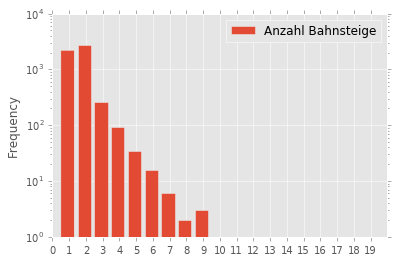

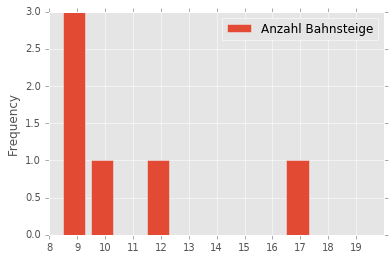

In [10]:
plot_hist(bs_count)
plt.figure()
cutoff = bs_count[bs_count["Anzahl Bahnsteige"] > 8]
dmax = cutoff.max()
cutoff.plot(kind='hist', bins=np.arange(8, 20)-0.5, xticks=np.arange(8, 20), width=0.8)
plt.xlim([8, dmax.item()])

## Baulänge

Zuerst entfernen wir Zeilen, die über alle Spalten Duplikate sind, sodass ein Bahnsteig mit einer spezifischen Länge nur noch einmal enthalten ist. Das entfernt 2 Fälle:

* an einem Bahnsteig ist links ein Gleis X, rechts ein Gleis Y, links und rechts ist der Bahnsteig gleich lang
* mehr als 1 Gleis ist an einem Bahnsteig und der Längenwert für einen Bahnsteig unterscheidet sich zwischen den einzelnen Gleisen, weil sie sich eine Bahnsteigplattform teilen. Der Hbf Erfurt bspw. hat einen Bahnsteig B02, an dem 6 verschiedene Gleise anliegen, davon aber 2 gleich lang sind.

In [11]:
d = data[["Bahnhofsnummer", "Bahnhofsname", "Bahnsteigsnummer", "Baulaenge"]].drop_duplicates()
d = d.assign(Baulaenge=d["Baulaenge"]/1000)

Mal sehen, wie viele Kilometer Bahnsteig es gibt…

In [12]:
d["Baulaenge"].sum()

1788.048370000018

[Wolframalpha](https://www.wolframalpha.com/input/?i=1788%20km&dataset=) weiß mehr über diese Länge.

…und welche Bahnhöfe die meisten Kilometer Bahnsteig auf sich vereinen

In [13]:
summed_length = d.groupby(["Bahnhofsnummer", "Bahnhofsname"]).sum()

In [14]:
summed_length.nlargest(10, "Baulaenge")

,,Baulaenge
Bahnhofsnummer,Bahnhofsname,
4234,München Hbf,6.7880
3107,Karlsruhe Hbf,5.4762
1866,Frankfurt (Main) Hbf,5.3670
3631,Leipzig Hbf,4.8390
1401,Düsseldorf Hbf,4.4560
1690,Essen Hbf,3.9460
4593,Nürnberg Hbf,3.8500
3837,Ludwigshafen (Rhein) Hbf,3.5870
6071,Stuttgart Hbf,3.5430


…und welche die wenigsten

In [15]:
summed_length.nsmallest(10, "Baulaenge")

,,Baulaenge
Bahnhofsnummer,Bahnhofsname,
6245,Trebitz (b Könnern),0.025
632,Biesenrode,0.030
1961,Friesdorf Ost,0.030
6012,Stendal Vorbf,0.030
7481,Wieslensdorf,0.030
7965,Vatteröder Teich,0.030
7973,Tangermünde West,0.030
8021,Klostermansfeld Randsiedlung,0.030
8234,Calbe (Saale) Stadt,0.030


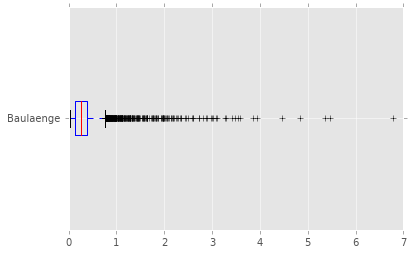

In [16]:
summed_length.boxplot(return_type='axes', vert=False)

# Fern- und Nahverkehr

Der Fernverkehr verkehrt an 306 von 5369 Bahnhöfen (das sind 5.70%)
Der Nahverkehr verkehrt an 5282 von 5369 Bahnhöfen (das sind 98.38%)


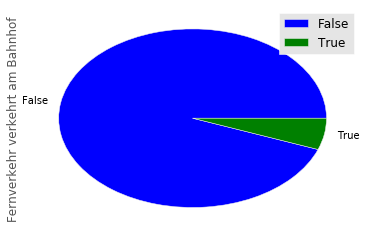

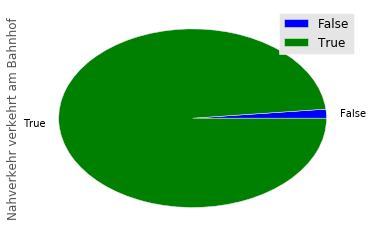

In [17]:
for col in ["Fernverkehr", "Nahverkehr"]:
    d = data[["Bahnhofsnummer", col]].drop_duplicates().groupby(col).count()
    does = d.Bahnhofsnummer[True]
    count = d.sum()
    print("Der %s verkehrt an %i von %i Bahnhöfen (das sind %.2f%%)" % (col, does, count, does/count*100))
    d.columns = ["%s verkehrt am Bahnhof" % col]
    plt.figure()
    d.plot(kind='pie', subplots=True)


Anscheinend findet an einigen Bahnhöfen kein Nahverkehr statt - welche sind das?

In [21]:
d = data[["Bahnhofsname", "Nahverkehr", "Fernverkehr"]].drop_duplicates().groupby(("Nahverkehr", "Fernverkehr"))
d.get_group((False, True))

,Bahnhofsname,Nahverkehr,Fernverkehr
178,Frankfurt am Main Flughafen Fernbahnhof,False,True
459,Limburg Süd,False,True


Findet an manchen weder Fern- noch Nahverkehrt statt?

In [22]:
d.get_group((False, False))

,Bahnhofsname,Nahverkehr,Fernverkehr
148,Pfungstadt,False,False
556,Annweiler-Sarnstall,False,False
601,Frankenthal-Süd,False,False
679,Landau (Pfalz) Süd,False,False
712,Neustadt Süd,False,False
795,Wörth Zügelstraße,False,False
1329,Dienheim,False,False
1477,Burbach Mitte,False,False
2951,Oldenburg-Wechloy,False,False
3013,Kirchhammelwarden,False,False
